In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Document Alignment

In [4]:
image_reference = cv2.imread("../data/images/form.jpg")
image = cv2.imread("../data/images/scanned-form.jpg")

Text(0.5, 1.0, 'Reference Form')

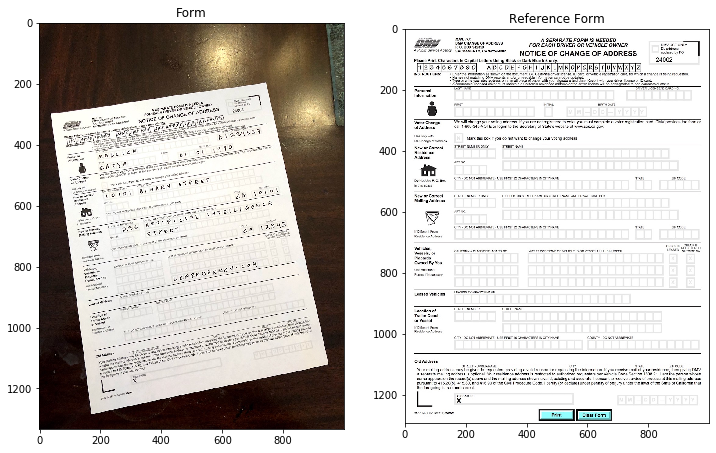

In [5]:
plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(image[:,:,::-1])
plt.title("Form")

plt.subplot(122)
plt.imshow(image_reference[:,:,::-1])
plt.title("Reference Form")

In [6]:
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_gray_reference = cv2.cvtColor(image_reference,cv2.COLOR_BGR2GRAY)

In [7]:
orb = cv2.ORB_create(500)

In [8]:
key_pts1,des1 = orb.detectAndCompute(image_gray,None)
key_pts2,des2 = orb.detectAndCompute(image_gray_reference,None)

In [9]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING,True)

In [10]:
matches = bf.match(des1,des2)

In [11]:
matches = sorted(matches,key = lambda x : x.distance)
matches = matches[:int(0.15 * len(matches))]

In [12]:
output = cv2.drawMatches(image,key_pts1,image_reference,key_pts2,matches,None)

Text(0.5, 1.0, 'Matches')

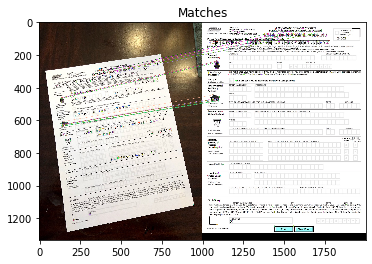

In [13]:
plt.imshow(output[:,:,::-1]);
plt.title("Matches")

In [17]:
src_points = np.zeros((len(matches),2),dtype = np.float32)
dst_points = np.zeros((len(matches),2),dtype = np.float32)

for i,match in enumerate(matches):
    src_points[i,:] = key_pts1[match.queryIdx].pt
    dst_points[i,:] = key_pts2[match.trainIdx].pt

In [19]:
h,status = cv2.findHomography(src_points,dst_points,cv2.RANSAC)

In [21]:
image_aligned = cv2.warpPerspective(image,h,(image_reference.shape[1],image_reference.shape[0]))

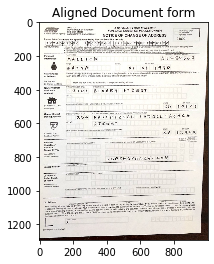

In [22]:
plt.imshow(image_aligned[:,:,::-1]);
plt.title("Aligned Document form");

## Detecting book in image

In [23]:
image1 = cv2.imread("../data/images/book.jpeg")
image2 = cv2.imread("../data/images/book_scene.jpeg")

In [24]:
image1_gray = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
image2_gray = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

In [25]:
max_features = 1000
min_match_count = 50

In [26]:
orb = cv2.ORB_create(max_features)

In [27]:
key_pts1,des1 = orb.detectAndCompute(image1_gray,None)
key_pts2,des2 = orb.detectAndCompute(image2_gray,None)

In [28]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6,
                   key_size = 12,
                   multi_probe_level = 1)
search_params = dict(checks = 100)

In [29]:
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [30]:
matches = flann.knnMatch(des1,des2,k =2)

In [31]:
good_matches = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good_matches.append(m)

In [37]:
if len(good_matches) > min_match_count:
    src_points = np.zeros((len(good_matches),2),dtype = np.float32)
    dst_points = np.zeros((len(good_matches),2),dtype = np.float32)
    
    for i,match in enumerate(good_matches):
        src_points[i,:] = key_pts1[match.queryIdx].pt
        dst_points[i,:] = key_pts2[match.trainIdx].pt
    
    src_points = src_points.reshape(-1,1,2)
    dst_points = dst_points.reshape(-1,1,2)
    h,status = cv2.findHomography(src_points,dst_points,cv2.RANSAC)
    
    H,W = image1.shape[:2]
    src_corner_points = np.float32([[0,0],[int(W-1),0],[int(W-1),int(H-1)],[0,int(H-1)]]).reshape(-1,1,2)
    dst_corner_points = cv2.perspectiveTransform(src_corner_points,h)
    dst_image2 = cv2.polylines(image2,[np.int32(dst_corner_points)],True,(0,0,255),10,cv2.LINE_AA)

In [39]:
output_image = cv2.drawMatches(image1,key_pts1,dst_image2,key_pts2,good_matches,None)

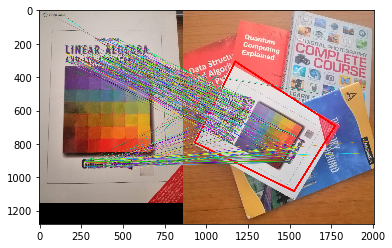

In [40]:
plt.imshow(output_image[:,:,::-1])